In [49]:
import pandas as pd
from apyori import apriori
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import subprocess
import re

In [28]:
df_retail = pd.read_csv('online retail.csv',header=0,encoding = 'unicode_escape')

C:\Users\n10074520\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df_retail.info()
print(df_retail.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532619 entries, 0 to 532618
Data columns (total 8 columns):
InvoiceNo      532619 non-null object
StockCode      532619 non-null object
Description    531165 non-null object
Quantity       532619 non-null int64
InvoiceDate    532619 non-null object
UnitPrice      532619 non-null float64
CustomerID     397924 non-null float64
Country        532619 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 32.5+ MB
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21

In [30]:
def describeDataset(doc):
    """
    Print Details for each column
    """
    for cols in doc:
        print(df_retail[cols].unique())
        print(df_retail[cols].value_counts())
        print("-"*20)
        
describeDataset(df_retail)

[536365 536366 536367 ... 581585 581586 581587]
573585    1114
581219     749
581492     731
580729     721
558475     705
579777     687
581217     676
537434     675
580730     662
538071     652
580367     650
580115     645
581439     635
580983     629
578344     622
538349     620
578347     606
537638     601
537237     597
536876     593
576617     593
536592     592
537823     591
576837     585
579508     578
577078     572
537240     568
577358     561
576618     552
576840     544
          ... 
570294       1
570338       1
553659       1
570403       1
541505       1
565045       1
547519       1
570417       1
570440       1
570441       1
553652       1
570451       1
547522       1
570461       1
547531       1
541487       1
547524       1
570474       1
541482       1
570481       1
570485       1
570489       1
570493       1
547525       1
547526       1
547527       1
547528       1
547529       1
547530       1
572689       1
Name: InvoiceNo, Length: 22064, dtype

## 1. Can you identify data quality issues in this dataset for performing association analysis?

In [31]:
#remove negative values in quantiy column as it is not necessaory values in terms of analysis of association.
df_retail.drop(df_retail[df_retail.Quantity < 0].index, inplace=True)

In [32]:
# remove inappropriate values in StockCode
df_retail['StockCode'].replace(['85123A','85099B'],['85123','85099'],inplace = True)
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0073'].index, inplace=True)
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0069'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0068'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0067'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'DCGS0003'].index, inplace=True) 
df_retail.drop(df_retail[df_retail.StockCode == 'm'].index, inplace=True)
df_retail.drop(df_retail[df_retail.StockCode == 'POST'].index, inplace=True)
df_retail.drop(df_retail[df_retail.StockCode == 'S'].index, inplace=True)

In [33]:
df_retail['StockCode'].unique()
df_retail['StockCode'].value_counts()

85123     2270
85099     2115
22423     2019
47566     1707
20725     1595
84879     1489
22197     1426
22720     1401
21212     1370
20727     1328
22383     1327
22457     1263
23203     1250
22386     1238
22469     1227
22086     1200
21931     1197
22411     1190
22382     1179
20728     1174
22961     1169
23298     1167
22960     1142
22666     1133
23209     1124
22384     1117
82482     1111
22993     1102
22699     1084
22727     1074
          ... 
23605        1
85224        1
84750A       1
22146        1
23617        1
84963B       1
90100        1
84613C       1
47591b       1
84661a       1
90048        1
46776f       1
35597B       1
90127A       1
85126        1
21410        1
17028J       1
84206B       1
35951        1
62095B       1
84705C       1
22275        1
21310        1
35833G       1
85115B       1
90037A       1
84854        1
47016        1
21160        1
90142A       1
Name: StockCode, Length: 3936, dtype: int64

## 2. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.

In [34]:
df_retail = df_retail.dropna(subset = ['Description'])

In [35]:
transactions = df_retail.groupby(['InvoiceNo'])['Description'].apply(list)
print(transactions.head(5))

InvoiceNo
536365    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536366    [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
536367    [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368    [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                           [BATH BUILDING BLOCK WORD]
Name: Description, dtype: object


InvoiveNo and Description were variables are included in the analysis.

## 3. Conduct association mining and answer the following: a. What is the highest lift value for the resulting rules? Which rule has this value? 

In [36]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 


In [37]:
# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)
results = list(apriori(transaction_list, min_support=0.005, min_confidence = 0.2, min_lift = 3, min_length = 2, max_length = 2))

# print first 5 rules
print(results[:5])


[RelationRecord(items=frozenset({'SPACEBOY BEAKER', ' DOLLY GIRL BEAKER'}), support=0.006181763796799441, ordered_statistics=[OrderedStatistic(items_base=frozenset({' DOLLY GIRL BEAKER'}), items_add=frozenset({'SPACEBOY BEAKER'}), confidence=0.7126436781609194, lift=77.68978010994502), OrderedStatistic(items_base=frozenset({'SPACEBOY BEAKER'}), items_add=frozenset({' DOLLY GIRL BEAKER'}), confidence=0.6739130434782608, lift=77.68978010994502)]), RelationRecord(items=frozenset({'LUNCH BOX I LOVE LONDON', ' SET 2 TEA TOWELS I LOVE LONDON '}), support=0.005035146318360836, ordered_statistics=[OrderedStatistic(items_base=frozenset({' SET 2 TEA TOWELS I LOVE LONDON '}), items_add=frozenset({'LUNCH BOX I LOVE LONDON'}), confidence=0.37546468401486993, lift=10.652681890600107)]), RelationRecord(items=frozenset({'12 PENCILS SMALL TUBE RED RETROSPOT', '12 PENCIL SMALL TUBE WOODLAND'}), support=0.0066304402014058525, ordered_statistics=[OrderedStatistic(items_base=frozenset({'12 PENCIL SMALL TUB

In [38]:
result_df = convert_apriori_results_to_pandas_df(results)
print(result_df.head(20))

                              Left_side                           Right_side  \
0                     DOLLY GIRL BEAKER                      SPACEBOY BEAKER   
1                       SPACEBOY BEAKER                    DOLLY GIRL BEAKER   
2       SET 2 TEA TOWELS I LOVE LONDON               LUNCH BOX I LOVE LONDON   
3         12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT   
4   12 PENCILS SMALL TUBE RED RETROSPOT        12 PENCIL SMALL TUBE WOODLAND   
5         12 PENCIL SMALL TUBE WOODLAND          12 PENCILS SMALL TUBE SKULL   
6           12 PENCILS SMALL TUBE SKULL        12 PENCIL SMALL TUBE WOODLAND   
7         12 PENCIL SMALL TUBE WOODLAND              LUNCH BAG RED RETROSPOT   
8         12 PENCIL SMALL TUBE WOODLAND      PACK OF 72 RETROSPOT CAKE CASES   
9         12 PENCIL SMALL TUBE WOODLAND      PAPER CHAIN KIT 50'S CHRISTMAS    
10        12 PENCIL SMALL TUBE WOODLAND      SET 12 COLOUR PENCILS SPACEBOY    
11      SET 12 COLOUR PENCILS SPACEBOY  

In [39]:
# sort all acquired rules descending by lift
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(15))

                                Left_side  \
1486      CHRISTMAS TREE HEART DECORATION   
1485  CHRISTMAS TREE DECORATION WITH BELL   
1488       CHRISTMAS TREE STAR DECORATION   
1487  CHRISTMAS TREE DECORATION WITH BELL   
5594           SET/6 COLLAGE PAPER PLATES   
5593             SET/6 COLLAGE PAPER CUPS   
4415         PACK OF 6 SKULL PAPER PLATES   
4414           PACK OF 6 SKULL PAPER CUPS   
1592             DOLLY GIRL CHILDRENS CUP   
1591            DOLLY GIRL CHILDRENS BOWL   
1491       CHRISTMAS TREE STAR DECORATION   
1490      CHRISTMAS TREE HEART DECORATION   
2581                    HERB MARKER THYME   
2580                 HERB MARKER ROSEMARY   
2565                  HERB MARKER PARSLEY   

                               Right_side   Support  Confidence       Lift  
1486  CHRISTMAS TREE DECORATION WITH BELL  0.005484    0.611111  98.066222  
1485      CHRISTMAS TREE HEART DECORATION  0.005484    0.880000  98.066222  
1488  CHRISTMAS TREE DECORATION WITH BELL  0.005

From the result above, the highest lift value is 100.76. There re two rules having this value: 
CHRISTMAS TREE DECORATION WITH BELL -> CHRISTMAS TREE HEART DECORATION and CHRISTMAS TREE HEART DECORATION -> CHRISTMAS TREE DECORATION WITH BELL.  

## b. What is the highest confidence value for the resulting rules? Which rule has this value? 

In [40]:
result_df = result_df.sort_values(by='Confidence', ascending=False)
print(result_df.head(15))

                                Left_side                          Right_side  \
519   BEADED CRYSTAL HEART GREEN ON STICK                      DOTCOM POSTAGE   
536    BEADED CRYSTAL HEART PINK ON STICK                      DOTCOM POSTAGE   
851              CANDY SPOT CUSHION COVER                      DOTCOM POSTAGE   
2581                    HERB MARKER THYME                HERB MARKER ROSEMARY   
2564                  HERB MARKER CHIVES                  HERB MARKER PARSLEY   
2580                 HERB MARKER ROSEMARY                   HERB MARKER THYME   
1911                SOFT PINK ROSE TOWEL                       DOTCOM POSTAGE   
5219               REGENCY TEA PLATE PINK            REGENCY TEA PLATE GREEN    
2562                  HERB MARKER CHIVES                     HERB MARKER MINT   
2568                  HERB MARKER CHIVES                    HERB MARKER THYME   
2566                  HERB MARKER CHIVES                 HERB MARKER ROSEMARY   
2576                  HERB M

From the result above, the highest confidence value is 98.83%. The rule has this value is BEADED CRYSTAL HEART GREEN ON STICK -> DOTCOM POSTAGE. 

## c. Discuss and explain the results. Interpret them to discuss the rule-set obtained.

In [41]:
support = result_df['Support'].as_matrix()
confidence = result_df['Confidence'].as_matrix()
lift = result_df['Lift'].as_matrix()
lift

C:\Users\n10074520\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\n10074520\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\n10074520\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([28.00247996, 27.64425292, 26.74533333, ...,  3.54086496,
        4.86278788,  3.03924242])

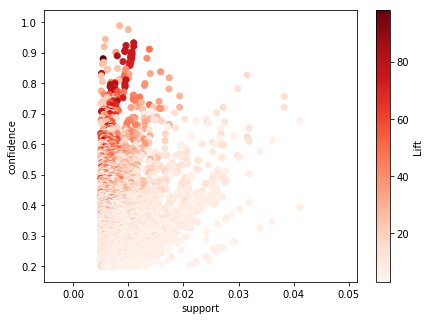

In [42]:
plt.figure(3, figsize=(7,5))
plt.scatter(support, confidence, c=lift, cmap='Reds')
plt.xlabel('support')
plt.ylabel('confidence') 

plt.colorbar().set_label('Lift')

## 4. The store is particularly interested in products that individuals purchase when they buy “HERB MARKER CHIVES”. 

### a. How many rules are in the subset?

There are 5 rules are in the subset.

In [43]:
search = result_df[result_df['Left_side'] == 'HERB MARKER CHIVES ']
print(search)

                Left_side            Right_side   Support  Confidence  \
2564  HERB MARKER CHIVES    HERB MARKER PARSLEY  0.009622    0.923445   
2562  HERB MARKER CHIVES       HERB MARKER MINT  0.009472    0.909091   
2568  HERB MARKER CHIVES      HERB MARKER THYME  0.009422    0.904306   
2566  HERB MARKER CHIVES   HERB MARKER ROSEMARY  0.009422    0.904306   
2553  HERB MARKER CHIVES      HERB MARKER BASIL  0.009073    0.870813   

           Lift  
2564  77.829339  
2562  75.981061  
2568  76.537884  
2566  75.581160  
2553  72.180355  


### b. Based on the rules, what are the other products these individuals are most likely to purchase? 

From the result above, the most common bought items with 'HERB MARKER CHIVES' are 'HERB MARKER PARSLEY', 'HERB MARKER MINT', 'HERB MARKER ROSEMARY'.

## 5. Can you perform sequence analysis on this dataset? If yes, present your results. If not, rationalise why?


In [63]:
df_seq = df_retail[['InvoiceNo', 'Description', 'Quantity']].sort_values(by=['Quantity'], ascending=True).dropna()
transactions = df_seq.groupby(['InvoiceNo', 'Quantity'])['Description'].apply(list)
sequences = transactions.values.tolist()

# show the first 5 sequences
print(sequences[:5])

[['SET 7 BABUSHKA NESTING BOXES'], ['WHITE METAL LANTERN', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.', 'GLASS STAR FROSTED T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'], ['CREAM CUPID HEARTS COAT HANGER'], ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'], ['BOX OF VINTAGE ALPHABET BLOCKS']]


In [68]:
from collections import defaultdict
import subprocess
import re
def get_association_rules(sequences, min_sup, min_conf):
    # step 1: create required input for SPMF
    
    # prepare a dict to uniquely assign each item in the transactions to an int ID
    item_dict = defaultdict(int)
    output_dict = defaultdict(str)
    item_id = 1
    
    # write your sequences in SPMF format
    with open('seq_rule_input.txt', 'w+') as f:
        for sequence in sequences:
            z = []
            for itemset in sequence:
                # if there are multiple items in one itemset
                if isinstance(itemset, list):
                    for item in itemset:
                        if item not in item_dict:
                            item_dict[item] = item_id
                            item_id += 1

                        z.append(item_dict[item])
                else:
                    if itemset not in item_dict:
                        item_dict[itemset] = item_id
                        output_dict[str(item_id)] = itemset
                        item_id += 1
                    z.append(item_dict[itemset])
                    
                # end of itemset
                z.append(-1)
            
            # end of a sequence
            z.append(-2)
            f.write(' '.join([str(x) for x in z]))
            f.write('\n')
    
    # run SPMF with supplied parameters
    supp_param = '{}%'.format(int(min_sup * 100))
    conf_param = '{}%'.format(int(min_conf * 100))
    subprocess.call(['java', '-jar', 'C:/Users/n10074520/Desktop/Assignment/IFN645CASE2/spmf.jar', 'run', 'RuleGrowth', 'seq_rule_input.txt', 'C:/Users/n10074520/Desktop/Assignment/IFN645CASE2/seq_rule_output.txt', supp_param, conf_param], shell=True)
    
    # read back the output rules
    outputs = open('C:/Users/n10074520/Desktop/Assignment/IFN645CASE2/seq_rule_output.txt', 'r').read().strip().split('\n')
    output_rules = []
    for rule in outputs:
        left, right, sup, conf = re.search(pattern=r'([0-9\,]+) ==> ([0-9\,]+) #SUP: ([0-9]+) #CONF: ([0-9\.]+)', string=rule).groups()
        sup = int(sup) / len(sequences)
        conf = float(conf)
        output_rules.append([[output_dict[x] for x in left.split(',')], [output_dict[x] for x in right.split(',')], sup, conf])
    
    # return pandas DataFrame
    return pd.DataFrame(output_rules, columns = ['Left_rule', 'Right_rule', 'Support', 'Confidence'])


In [75]:
rule = get_association_rules(sequences, 0.05, 0.7)

AttributeError: 'NoneType' object has no attribute 'groups'

## 6. How the outcome of this study can be used by decision makers?

The company can use the rules to obtain the understanding oc consumers' needs and behaviours. Decision makers will understand that there are several items that are often bought together. If they can put these items together, revenue can get increased. 